In [1]:
from logging import warning
import os 
import pandas as pd
import numpy as np
import pickle 

from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, make_scorer, confusion_matrix
from xgboost import XGBClassifier

import warnings

import processing
import event_manager
import epoching 
import model_training

warnings.filterwarnings('ignore')

<h1> Training ML <h1>

In [10]:
file = '../../data/data_model/data_epoching.csv'
file = '../../data/data_model/data_epoching_stft_new.ftr'
file = '../../data/data_model/data_epoching_event.ftr'

In [11]:
if file.endswith('.csv'):
    data= pd.read_csv(file,index_col=0)
elif file.endswith('.ftr'):
    data= pd.read_feather(file)
data = data[data.label!=3]
data.label.value_counts()

0    731521
1     45564
2     11049
Name: label, dtype: int64

In [12]:
df = pd.read_csv('../../data/filename_train_test.txt',delimiter='\t',header=None)
df.columns=['file','train_test_split']
data = data.merge(df,on='file',how='left')

In [27]:
data.to_feather('data_last.ftr')

In [13]:
X_train = data[data['train_test_split'] == 'train'].drop(columns=['label','train_test_split','file']).to_numpy()
X_test = data[data['train_test_split'] == 'test'].drop(columns=['label','train_test_split','file']).to_numpy()
y_train = data.loc[data['train_test_split'] == 'train','label'].to_numpy()
y_test = data.loc[data['train_test_split'] == 'test','label'].to_numpy()
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(477816, 201) (477816,)
(310318, 201) (310318,)


In [14]:
X_train = X_train[:80000,:]
y_train = y_train[:80000]

In [15]:
print(X_train.shape)

(80000, 201)


In [8]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

In [16]:
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train,y_train)

In [19]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
pca = PCA(n_components=0.95)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [20]:
logistic = XGBClassifier()
logistic.fit(X_train,y_train)
#logistic.fit(X_train,y_train,sample_weight=classes_weights)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [21]:
ytest_predict = logistic.predict(X_test)
print(classification_report(y_pred=ytest_predict,y_true=y_test))
print(confusion_matrix(y_pred=ytest_predict,y_true=y_test))

              precision    recall  f1-score   support

           0       0.94      0.87      0.90    290718
           1       0.07      0.16      0.10     16099
           2       0.06      0.11      0.08      3501

    accuracy                           0.82    310318
   macro avg       0.36      0.38      0.36    310318
weighted avg       0.89      0.82      0.85    310318

[[252830  32441   5447]
 [ 13229   2513    357]
 [  2700    415    386]]


<h1>Test real time<h1>

In [22]:
audio_folder = '../../data/ICBHI_final_database'
list_audio_files = processing.get_list_recording(audio_folder)
print('Found {} recording files'.format(len(list_audio_files)))
audio_file = list_audio_files[47]
print(audio_file)

Found 920 recording files
107_2b3_Ar_mc_AKGC417L


In [23]:
data_file = processing.load_file_from_recording_name(audio_folder,audio_file)
data_filtered,df_label = processing.preprocess_data(data_file,annotations='event')
data_feature= processing.apply_stft(data_filtered,n_fft=400,center=False)
df_label = event_manager.segment_event_annotation(data_filtered,data_feature['time'])
print(df_label.shape)
print(data_feature['data'].shape)

(797, 3)
(201, 797)


In [24]:
Xsample_test = data_feature['data'].T
Xsample_test = scaler.transform(Xsample_test)
Xsample_test = pca.transform(Xsample_test)

ysample_prediction = logistic.predict(Xsample_test)
#ysample_prediction = (logistic.predict_proba(Xsample_test) >= 0.9).astype(int).argmax(axis=1)
ysample_prediction_prob = logistic.predict_proba(Xsample_test)
df_label['ysample_prediction'] = ysample_prediction
df_label['correct'] = np.where(df_label['ysample_prediction'] == df_label['label'],1,0)

In [25]:
df_label['correct'].sum()/df_label.shape[0]

0.7440401505646174

(0.0, 20.0)

<Figure size 1400x500 with 0 Axes>

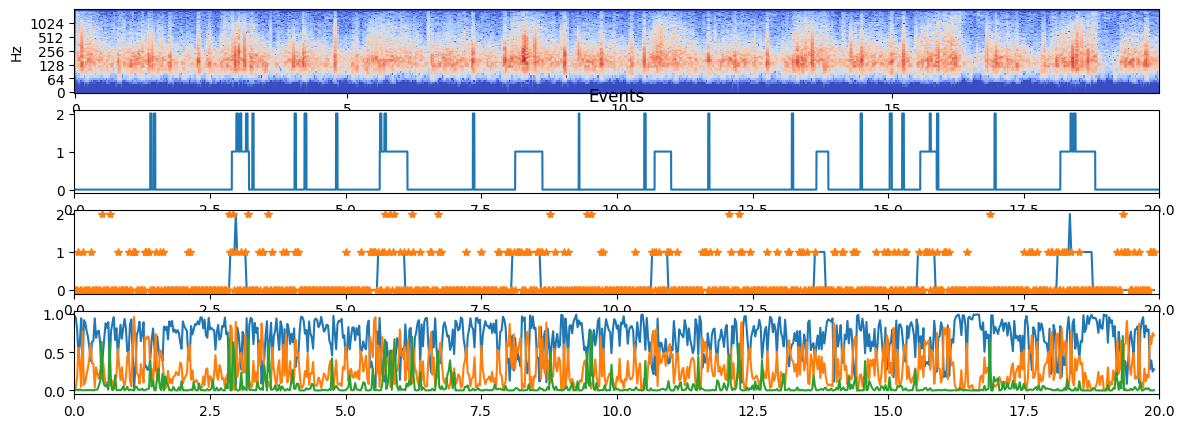

In [26]:
import matplotlib.pyplot as plt
import librosa

f = plt.figure(figsize=(14, 5))
n_fft = 400
f = plt.figure(figsize=(14, 5))
ax = f.add_subplot(411)
librosa.display.specshow(data_feature['data'], 
                         sr=data_filtered['fs'],n_fft=n_fft, hop_length=n_fft/4,
                         x_axis='time', y_axis='log')
ax = f.add_subplot(412)
ax.plot(data_filtered['time'],data_filtered['label'])
ax.set_xlim([data_filtered['time'][0],data_filtered['time'][-1]])
ax.set_title('Events',y=1)
ax = f.add_subplot(413)
ax.plot(df_label['start'],df_label['label'],'-')
ax.plot(df_label['start'],df_label['ysample_prediction'],'*')
ax.set_xlim([data_filtered['time'][0],data_filtered['time'][-1]])
ax = f.add_subplot(414)
ax.plot(df_label['start'],ysample_prediction_prob)
ax.set_xlim([data_filtered['time'][0],data_filtered['time'][-1]])